In [1]:
import pandas as pd
sub = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv", sep= "\t", header = None)
sub.columns = ["The Protein ID", "The Gene Ontology term (GO) ID", "Predicted link probability that GO appear in Protein"]
sub.head(5)

,The Protein ID,The Gene Ontology term (GO) ID,Predicted link probability that GO appear in Protein
0,A0A0A0MRZ7,GO:0000001,0.123
1,A0A0A0MRZ7,GO:0000002,0.123
2,A0A0A0MRZ8,GO:0000001,0.123
3,A0A0A0MRZ8,GO:0000002,0.123
4,A0A0A0MRZ9,GO:0000001,0.123


In [2]:
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_embeddings.npy
/kaggle/input/train-targets-top500/train_targets_top500.npy
/kaggle/input/23468234/train_ids_esm2_t33_650M_UR50D.npy
/kaggle/input/23468234/test_ids_esm2_t33_650M_UR50D.npy
/kaggle/input/23468234/test_embeds_esm2_t33_650M_UR50D.npy
/kaggle/input/23468234/train_embeds_esm2_t33_650M_UR50D.npy
/kaggle/input/cafa2008/submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Trai

In [3]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 10
    batch_size = 128
    lr = 0.01
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(config.device)

cpu


In [5]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy"
#     "EMS2" : "23468234"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280
}

In [6]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
        if embeddings_source == "T5":
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            np_labels = np.load(
                "/kaggle/input/train-targets-top"+str(config.num_labels)+ \
                "/train_targets_top"+str(config.num_labels)+".npy")
            df_labels = pd.DataFrame(self.df['EntryID'])
            df_labels['labels_vect']=[row for row in np_labels]
            self.df = self.df.merge(df_labels, on="EntryID")
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id
        

## MODEL ARCHITECTURE BUILDING AND TRAINING

In [7]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 864)
        self.activation1 = torch.nn.ReLU() 
        self.linear2 = torch.nn.Linear(864, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)
      

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [8]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=864)
        self.fc2 = nn.Linear(in_features=864, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.tanh(self.conv1(x)))
        x = self.pool2(nn.functional.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
def train_model(embeddings_source, model_type="linear", train_size=0.85):
    
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [10]:
# ems2_model, ems2_losses, ems2_scores = train_model(embeddings_source="EMS2",model_type="convolutional")

In [11]:
# t5_model, t5_losses, t5_scores = train_model(embeddings_source="T5",model_type="linear")

In [12]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 945/945 [00:34<00:00, 27.51it/s]


Running Average TRAIN Loss :  138.73560334059297
Running Average TRAIN F1-Score :  0.09562447302082859
Running Average VAL Loss :  136.31202999274888
Running Average VAL F1-Score :  0.11935236974212224


EPOCH  2


100%|██████████| 945/945 [00:34<00:00, 27.32it/s]


Running Average TRAIN Loss :  136.68937836500703
Running Average TRAIN F1-Score :  0.1249931320784584
Running Average VAL Loss :  135.58035305731312
Running Average VAL F1-Score :  0.13357480575224598


EPOCH  3


100%|██████████| 945/945 [00:35<00:00, 26.80it/s]


Running Average TRAIN Loss :  136.11658401085586
Running Average TRAIN F1-Score :  0.13239584564374238
Running Average VAL Loss :  135.13076435020585
Running Average VAL F1-Score :  0.13498512209354047


EPOCH  4


100%|██████████| 945/945 [00:34<00:00, 27.41it/s]


Running Average TRAIN Loss :  135.80968498754754
Running Average TRAIN F1-Score :  0.1370993725048802
Running Average VAL Loss :  134.759537611179
Running Average VAL F1-Score :  0.1394403500560515


EPOCH  5


100%|██████████| 945/945 [00:35<00:00, 26.88it/s]


Running Average TRAIN Loss :  135.4824173942445
Running Average TRAIN F1-Score :  0.14017447997180243
Running Average VAL Loss :  134.56811432067505
Running Average VAL F1-Score :  0.14305335550964948


EPOCH  6


100%|██████████| 945/945 [00:34<00:00, 27.29it/s]


Running Average TRAIN Loss :  135.32419863907748
Running Average TRAIN F1-Score :  0.1423543733500299
Running Average VAL Loss :  134.8114454075248
Running Average VAL F1-Score :  0.14398281766982848


EPOCH  7


100%|██████████| 945/945 [00:35<00:00, 26.62it/s]


Running Average TRAIN Loss :  135.11256239149304
Running Average TRAIN F1-Score :  0.14462194758905936
Running Average VAL Loss :  134.4607079785741
Running Average VAL F1-Score :  0.14603233605087873


EPOCH  8


100%|██████████| 945/945 [00:33<00:00, 27.83it/s]


Running Average TRAIN Loss :  134.97337783732743
Running Average TRAIN F1-Score :  0.14616659615563338
Running Average VAL Loss :  134.25796938228035
Running Average VAL F1-Score :  0.14788800915201267


EPOCH  9


100%|██████████| 945/945 [00:35<00:00, 26.83it/s]


Running Average TRAIN Loss :  134.99162429728835
Running Average TRAIN F1-Score :  0.14592704989765057
Running Average VAL Loss :  134.5065661675916
Running Average VAL F1-Score :  0.14492458627074065


EPOCH  10


100%|██████████| 945/945 [00:35<00:00, 26.75it/s]


Running Average TRAIN Loss :  134.85964472533533
Running Average TRAIN F1-Score :  0.1476956593059989
Running Average VAL Loss :  134.4508008214528
Running Average VAL F1-Score :  0.14560705789191994


TRAINING FINISHED
FINAL TRAINING SCORE :  0.1476956593059989
FINAL VALIDATION SCORE :  0.14560705789191994


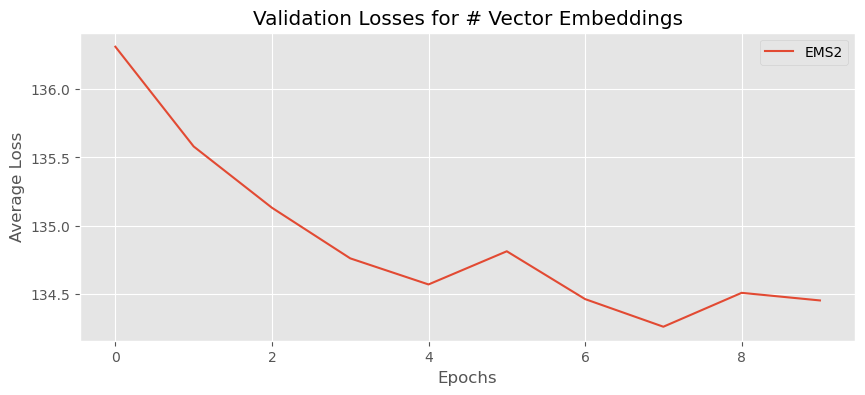

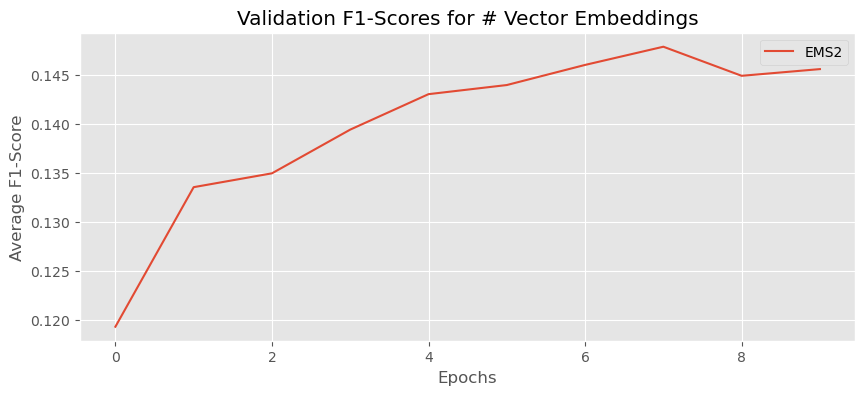

In [13]:
plt.figure(figsize = (10, 4))
#plt.plot(ems2_losses["val"], label = "EMS2")
#plt.plot(t5_losses["val"], label = "T5")
plt.plot(protbert_losses["val"], label = "EMS2") 
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
#plt.plot(ems2_scores["val"], label = "EMS2")
#plt.plot(t5_scores["val"], label = "T5")
plt.plot(protbert_scores["val"], label = "EMS2")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## PREDICTION

In [14]:
def predict(embeddings_source):
    
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model
        
    model.eval()
    
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [15]:
submission_df = predict("ProtBERT")

GENERATE PREDICTION FOR TEST SET...


141865it [01:23, 1690.01it/s]


PREDICTIONS DONE


In [16]:
len(submission_df)

70932500

<h4> SUBMISSION</h4>


In [17]:
submission_df.to_csv('submission.tsv', sep='\t', header=False, index=False)

In [18]:
#this submission was obtained by training models on BlastP, Sprof, QuickGo and DeeepGoZero offline
submission2 = pd.read_csv('/kaggle/input/blast-quick-sprof-zero-pred/submission.tsv',
    sep='\t', header=None, names=['Id2', 'GO term2', 'Confidence2']) 

In [19]:
subs = submission2.merge(submission_df, left_on=['Id2', 'GO term2'], 
                                                  right_on=['Id', 'GO term'], how='outer')

In [20]:
submission3 = pd.read_csv('/kaggle/input/cafa2008/submission.tsv',
    sep='\t', header=None, names=['Id2', 'GO term2', 'Confidence2']) 
subs = submission3.merge(submission_df, left_on=['Id2', 'GO term2'], 
                                                  right_on=['Id', 'GO term'], how='outer')

In [21]:
subs.drop(['Id', 'GO term'], axis=1, inplace=True)
subs['confidence_combined'] = subs.apply(lambda row: row['Confidence2'] if not np.isnan(row['Confidence2']) else row['Confidence'], axis=1)

In [22]:
subs[['Id2', 'GO term2', 'confidence_combined']].to_csv('submission.tsv', sep='\t', header=False, index=False)

In [23]:
# submission = pd.read_csv('/kaggle/input/cafa51208/submission.tsv',
#     sep='\t', header=None)

# submission.to_csv('submission.tsv',sep='\t', header=False, index=False)